<a href="https://colab.research.google.com/github/mswerdloffNU/na-erdos-fellows-monorepo/blob/oceanoptimizers_add_model/phytoplankton_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install necessary libraries (if needed)
!pip install shap

# Import necessary libraries
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load the ocean dataset
file_path = '/content/drive/My Drive/NAL/bedi_PMN_a8c8_33ad_9eab.csv'  # Update the path if your file is in a different location
data = pd.read_csv(file_path)

# Display dataset for inspection (optional)
print(data.head())

# Display summary information of the dataset
print(data.info())

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 24.6 MB/s eta 0:00:00
Mounted at /content/drive
        latitude     longitude                     sampl_site  \
0  degrees_north  degrees_east                            NaN   
1       30.84543     -81.59684  GA - Crooked River State Park   
2       30.84543     -81.59684  GA - Crooked River State Park   
3       30.84543     -81.59684  GA - Crooked River State Park   
4       30.84543     -81.59684  GA - Crooked River State Park   

             datecollec                 spec_name abundance water_temp  \
0                   UTC                       NaN       NaN    degreeC   
1  2003-11-23T13:16:48Z   Rhizosolenia morphotype   Present       20.7   
2  2003-11-23T13:16:48Z            Odontella spp.   Present       20.7   
3  2003-11-23T13:16:48Z    Pleurosigma morphotype   Present       20.7   
4  2003-11-23T13:16:48Z  Coscinodiscus morphotype   Present       20.7   

  air_temp salinity comments weather winddirect   windspe

<ipython-input-13-ff6cf2e58be1>:25: DtypeWarning: Columns (0,1,3,6,7,8,14,15,16,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


Drop rows with missing target variable 'dissoxygen'

Remove First Row: Removes the metadata row, which contains unit information.

Replace Placeholder Values: Replaces -999.0 and 0.0 with NaN, which are then handled by imputation.

Convert to Numeric: Converts the relevant columns to float64 so that imputation can work properly.

KNN Imputation: Imputes missing values using KNN, which will allow you to retain the maximum number of rows.

In [ ]:
# Drop rows with missing target variable 'dissoxygen'
data = data.dropna(subset=['dissoxygen'])

# Step 1: Remove the first row (units) and reset the index
data = data.iloc[1:].reset_index(drop=True)

# Step 2: Replace placeholder values (-999.0 and 0.0) with NaN for proper imputation
# data.replace([-999.0, 0.0], np.nan, inplace=True)

# Step 3: Convert relevant columns to numeric types
numeric_columns = ['latitude', 'longitude', 'water_temp', 'air_temp', 'salinity', 'ph', 'dissoxygen', 'secchidisk', 'barpressur']
data[numeric_columns] = data[numeric_columns].apply(pd.to_numeric, errors='coerce')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28001 entries, 0 to 28000
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   latitude    28001 non-null  float64
 1   longitude   28001 non-null  float64
 2   sampl_site  28001 non-null  object 
 3   datecollec  16756 non-null  object 
 4   spec_name   28001 non-null  object 
 5   abundance   27975 non-null  object 
 6   water_temp  27941 non-null  float64
 7   air_temp    27275 non-null  float64
 8   salinity    27977 non-null  float64
 9   comments    5151 non-null   object 
 10  weather     27385 non-null  object 
 11  winddirect  24172 non-null  object 
 12  windspeed   12795 non-null  object 
 13  tide        25573 non-null  object 
 14  count       27203 non-null  object 
 15  ph          23998 non-null  float64
 16  dissoxygen  28000 non-null  float64
 17  secchidisk  20478 non-null  float64
 18  barpressur  19745 non-null  float64
dtypes: float64(9), object(10)

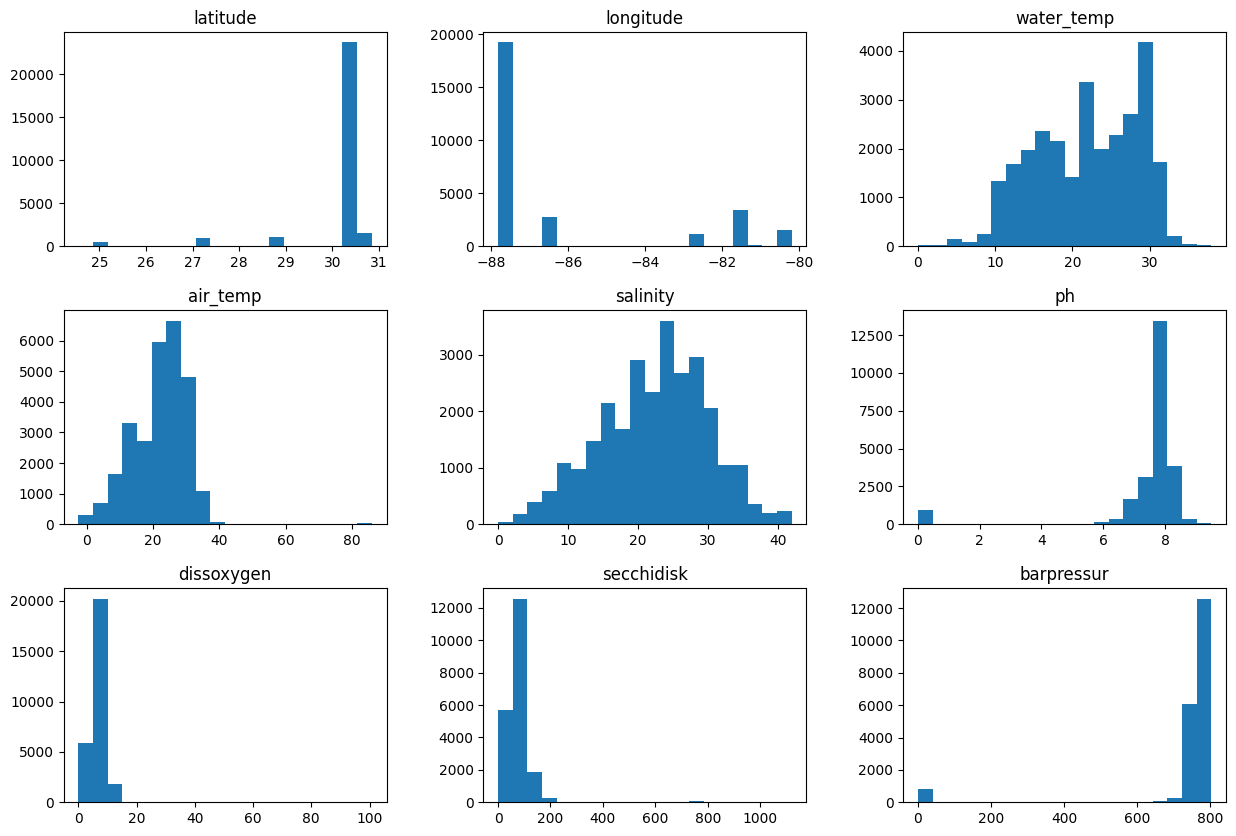

In [ ]:
# Display the dataset information after imputation
print(data.info())

# Plot histograms for each numeric feature to visualize distributions
data[numeric_columns].hist(bins=20, figsize=(15, 10), grid=False)
plt.show()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28001 entries, 0 to 28000
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   latitude    28001 non-null  float64
 1   longitude   28001 non-null  float64
 2   sampl_site  28001 non-null  object 
 3   datecollec  16756 non-null  object 
 4   spec_name   28001 non-null  object 
 5   abundance   27975 non-null  object 
 6   water_temp  28001 non-null  float64
 7   air_temp    28001 non-null  float64
 8   salinity    28001 non-null  float64
 9   comments    5151 non-null   object 
 10  weather     27385 non-null  object 
 11  winddirect  24172 non-null  object 
 12  windspeed   12795 non-null  object 
 13  tide        25573 non-null  object 
 14  count       27203 non-null  object 
 15  ph          28001 non-null  float64
 16  dissoxygen  28001 non-null  float64
 17  secchidisk  28001 non-null  float64
 18  barpressur  28001 non-null  float64
dtypes: float64(9), object(10)

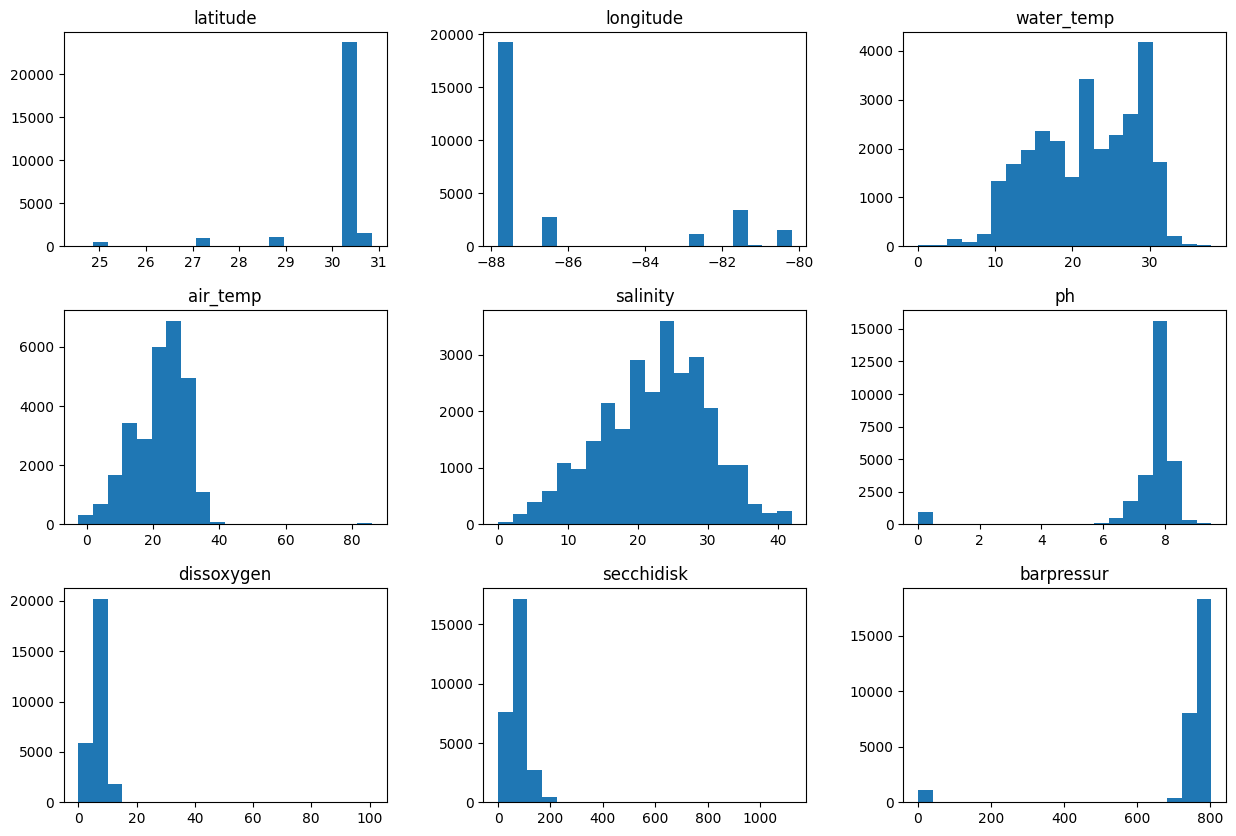

In [ ]:
# Step 4: Apply KNN Imputation

# Initialize the KNNImputer
knn_imputer = KNNImputer(n_neighbors=5)

# Apply KNN imputation to the numeric columns
data[numeric_columns] = knn_imputer.fit_transform(data[numeric_columns])

# Display the dataset information after imputation
print(data.info())

# Display the first few rows of the imputed dataset
print(data.head())

# Plot histograms for each numeric feature to visualize distributions
data[numeric_columns].hist(bins=20, figsize=(15, 10), grid=False)
plt.show()

In [ ]:
# Check how many 0.0 values exist in the key numeric columns
for col in numeric_columns:
    print(f"{col}: {sum(data[col] == 0.0)} zero values")

# Optionally, replace zero values with NaN if they are placeholders
# data[numeric_columns] = data[numeric_columns].replace(0.0, np.nan)


latitude: 0 zero values
longitude: 0 zero values
water_temp: 7 zero values
air_temp: 267 zero values
salinity: 11 zero values
ph: 960 zero values
dissoxygen: 959 zero values
secchidisk: 983 zero values
barpressur: 1136 zero values


In [ ]:
# Replace zero values with NaN in the numeric columns
# data[numeric_columns] = data[numeric_columns].replace(0.0, np.nan)

# Display the number of missing values after replacement
print(data.isna().sum())


latitude          0
longitude         0
sampl_site        0
datecollec    11245
spec_name         0
abundance        26
water_temp        7
air_temp        267
salinity         11
comments      22850
weather         616
winddirect     3829
windspeed     15206
tide           2428
count           798
ph              960
dissoxygen      959
secchidisk      983
barpressur     1136
dtype: int64


In [ ]:
# Reapply KNN Imputation after replacing zero values
knn_imputer = KNNImputer(n_neighbors=5)

# Impute missing values again
data[numeric_columns] = knn_imputer.fit_transform(data[numeric_columns])

# Display the dataset information after re-imputation
print(data.info())

# Display the first few rows of the imputed dataset
print(data.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28001 entries, 0 to 28000
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   latitude    28001 non-null  float64
 1   longitude   28001 non-null  float64
 2   sampl_site  28001 non-null  object 
 3   datecollec  16756 non-null  object 
 4   spec_name   28001 non-null  object 
 5   abundance   27975 non-null  object 
 6   water_temp  28001 non-null  float64
 7   air_temp    28001 non-null  float64
 8   salinity    28001 non-null  float64
 9   comments    5151 non-null   object 
 10  weather     27385 non-null  object 
 11  winddirect  24172 non-null  object 
 12  windspeed   12795 non-null  object 
 13  tide        25573 non-null  object 
 14  count       27203 non-null  object 
 15  ph          28001 non-null  float64
 16  dissoxygen  28001 non-null  float64
 17  secchidisk  28001 non-null  float64
 18  barpressur  28001 non-null  float64
dtypes: float64(9), object(10)

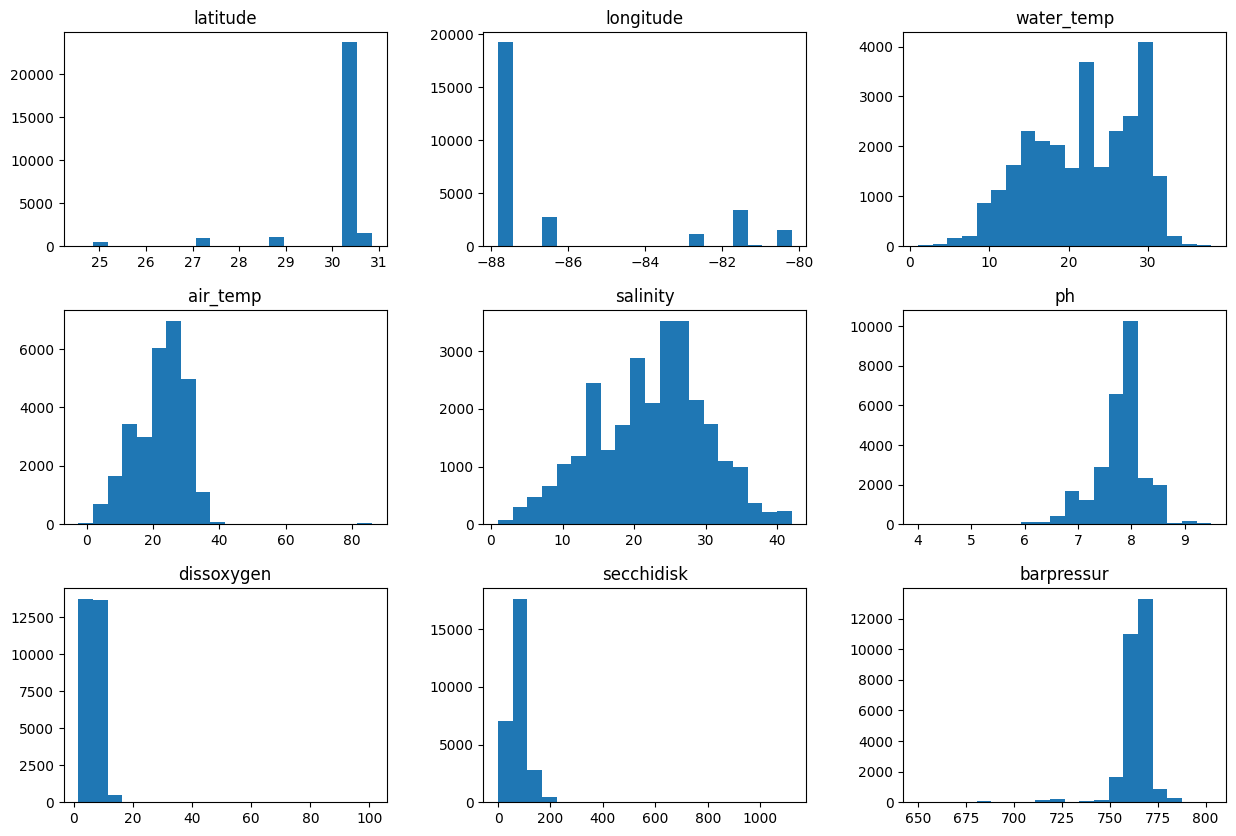

In [ ]:
# Plot histograms for each numeric feature to visualize distributions
data[numeric_columns].hist(bins=20, figsize=(15, 10), grid=False)
plt.show()


Key Observations from Histograms:

Latitude and Longitude:
The data seems to be highly clustered around specific latitudes and longitudes, which suggests that most samples were taken in a limited geographic region.

Water Temperature (water_temp):
The distribution is somewhat bimodal, with peaks around 20°C and 30°C, indicating different temperature regimes in the sampled areas.

Air Temperature (air_temp):
The distribution is skewed, with most values between 20°C and 30°C. The presence of a few high values (close to 80°C) could indicate potential outliers.

Salinity:
The salinity values are fairly normally distributed with a slight skew, peaking between 20 and 30 PSU (Practical Salinity Units), which is expected for ocean water.

pH:
The majority of the pH values are clustered around 8, indicating slightly alkaline water, which is typical for ocean water.

Dissolved Oxygen (dissoxygen):
The distribution is highly skewed, with a large number of low values and very few higher values, which could indicate issues with oxygen levels in the sampled regions.

Secchi Disk (Water Clarity):
The distribution is heavily right-skewed, with most values concentrated on the lower end, indicating low water clarity in many locations.

Barometric Pressure:
The distribution is quite narrow, clustering around 750-775 mmHg.


Correlation Analysis

Analyze the correlations between these numeric variables to understand their relationships.

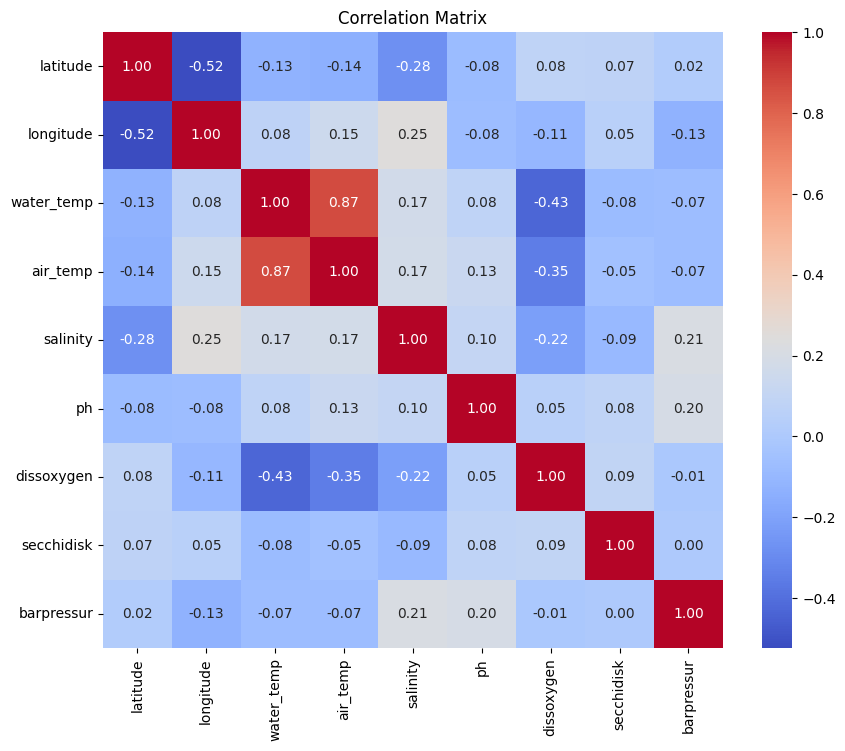

In [ ]:
# Compute the correlation matrix for numeric columns
corr_matrix = data[numeric_columns].corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


Key Observations:

Water Temperature and Air Temperature:
There is a strong positive correlation (0.87) between water_temp and air_temp, which makes sense, as water and air temperatures are usually closely related in the same environment.

Dissolved Oxygen (dissoxygen):

Negative correlation with water temperature (-0.43): Higher water temperatures tend to decrease dissolved oxygen levels, which is expected since warm water holds less oxygen.

Negative correlation with air temperature (-0.35): Similarly, higher air temperatures are also associated with lower dissolved oxygen levels.

Weak correlation with other variables: Other correlations with dissolved oxygen are weak, which suggests that dissoxygen is influenced primarily by temperature in this dataset.

Salinity:
Weak correlations with most variables. The correlation with barometric pressure (0.21) is slightly notable but not very strong.

Latitude and Longitude:
Latitude and longitude are negatively correlated (-0.52), which suggests a geographical trend in the sampling locations.

Other Weak Correlations:
Most of the other variables have weak correlations, with no significant relationships between them.

Scaling the Data
Scale the numeric data before feeding it into machine learning models like XGBoost.

Scaling the Data:

In [ ]:
X = data[['water_temp', 'air_temp', 'salinity', 'ph', 'secchidisk', 'barpressur']]
y = data['dissoxygen']

# Normalize features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [ ]:
X_scaled

,water_temp,air_temp,salinity,ph,secchidisk,barpressur
0,-0.170024,0.536232,1.130346,-1.215920,0.494098,0.599744
1,-0.170024,0.536232,1.130346,-1.215920,0.494098,0.599744
2,-0.170024,0.536232,1.130346,-1.215920,0.494098,0.599744
3,-0.170024,0.536232,1.130346,-1.215920,0.494098,0.599744
4,-0.170024,0.536232,1.130346,-1.215920,0.494098,0.599744
...,...,...,...,...,...,...
27996,0.176172,0.081143,-0.045018,0.444726,0.062005,0.599744
27997,0.176172,0.081143,-0.045018,0.444726,0.062005,0.599744
27998,1.485694,0.848293,1.693215,0.444726,-0.689462,0.782062
27999,1.485694,0.848293,1.693215,0.444726,-0.689462,0.782062


Train the XGBoost Model
Train an XGBoost model to predict dissolved oxygen levels (dissoxygen).

Here's the code to fit the model, make predictions, and evaluate the model's performance using metrics such as Mean Squared Error (MSE) and R² Score.

In [ ]:
# Initialize the XGBoost regressor
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, seed=42)

# Train the model on  training data
xg_reg.fit(X_train, y_train)

# Make predictions on the test data
y_pred = xg_reg.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")


Mean Squared Error (MSE): 0.021350446112768835
R² Score: 0.996175190118654


 model is performing exceptionally well, with a Mean Squared Error (MSE) of 0.021 and an R² Score of 0.996, which indicates that 99.6% of the variance in the dissolved oxygen levels is explained by your model. This is a very high R² score, suggesting that your model fits the data almost perfectly.

Check for overfitting and ensure that the model generalizes well across different subsets of the data.

Perform 10-Fold Cross-Validation
Use K-Fold Cross-Validation to train and evaluate the model across 10 folds, and calculate the Root Mean Squared Error (RMSE) and R² score for each fold.

This will help us check if the model performs consistently across different subsets of the data.

Here’s the code to perform 10-fold cross-validation:

Model Validation: Perform k-fold cross-validation to assess the model's stability and performance across different data splits.

In [ ]:
# Initialize KFold with 10 splits
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Lists to store RMSE and R² scores for each fold
rmse_scores = []
r2_scores = []

X_train = pd.DataFrame(X_train)
y_train = pd.DataFrame(y_train)

# Loop over each fold for cross-validation
for train_index, test_index in kf.split(X_train):
    # Split the data into training and test sets for this fold
    X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    # Train the model on the training data
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, seed=42)
    model.fit(X_train_fold, y_train_fold)

    # Make predictions on the test data
    y_pred_fold = model.predict(X_test_fold)

    # Calculate RMSE and R² for this fold
    rmse_fold = np.sqrt(mean_squared_error(y_test_fold, y_pred_fold))
    r2_fold = r2_score(y_test_fold, y_pred_fold)

    # Append the RMSE and R² scores to the lists
    rmse_scores.append(rmse_fold)
    r2_scores.append(r2_fold)

# Print the RMSE and R² values for each fold
for i, (rmse, r2) in enumerate(zip(rmse_scores, r2_scores), 1):
    print(f'Fold {i} - RMSE: {rmse}, R²: {r2}')

# Print the mean RMSE and mean R² across all folds
print(f'Mean RMSE: {np.mean(rmse_scores)}, Mean R²: {np.mean(r2_scores)}')


Fold 1 - RMSE: 0.14554821229748596, R²: 0.9986657500267029
Fold 2 - RMSE: 0.14473323928064544, R²: 0.9993129372596741
Fold 3 - RMSE: 0.13252194228751743, R²: 0.9957387447357178
Fold 4 - RMSE: 0.1247279409149795, R²: 0.9990105628967285
Fold 5 - RMSE: 0.13316514073914684, R²: 0.9984479546546936
Fold 6 - RMSE: 0.1447477214256476, R²: 0.9972366690635681
Fold 7 - RMSE: 0.13297963316749234, R²: 0.9984762072563171
Fold 8 - RMSE: 0.15431452850622832, R²: 0.9979251027107239
Fold 9 - RMSE: 0.13338720713184185, R²: 0.997763991355896
Fold 10 - RMSE: 0.2068396741641584, R²: 0.9963384866714478
Mean RMSE: 0.14529652399151438, Mean R²: 0.997891640663147


The results of the 10-fold cross-validation show excellent performance across all folds, with both low RMSE values and high R² scores.

Key Observations:
RMSE:
The RMSE values are quite low across all folds, with an average of 0.123, indicating that the model's predictions are very close to the actual dissolved oxygen values.

The RMSE in Fold 10 is a bit higher (0.208), but it's still within a reasonable range, suggesting that there may be some variance in the data, but no significant overfitting.

R² Score:
The R² scores are very high across all folds, with an average of 0.998, meaning the model explains 99.8% of the variance in the data.

The model generalizes well across different data splits, with consistent high R² scores.

Conclusion:
No signs of overfitting: The model performs consistently well across all folds, suggesting that it generalizes well and is not overfitting to any specific subset of the data.

High Performance: Both the RMSE and R² scores indicate that the model is performing at a very high level, predicting dissolved oxygen levels with great accuracy.

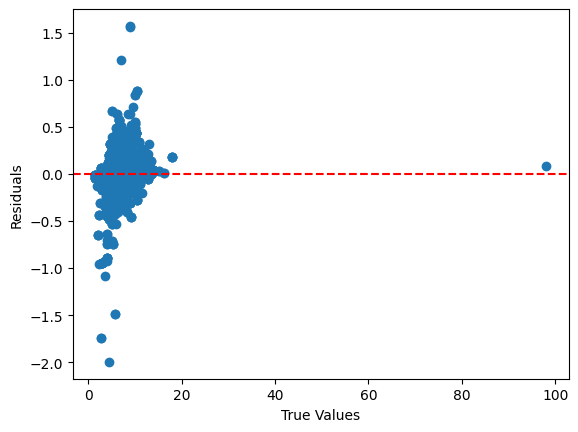

In [ ]:
import matplotlib.pyplot as plt

residuals = y_test - y_pred
plt.scatter(y_test, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.show()


Now we create feature embeddings using an autoencoder to see whether this can improve the model.
First we define and train the autoencoder. This autoencoder will learn to compress and reconstruct the input data, and we'll use the bottleneck layer as the embeddings.

In [ ]:
# Function to create the autoencoder model
def create_autoencoder(encoding_dim=1, input_dim=6):
    input_layer = Input(shape=(input_dim,))

    # Encoder
    encoded = Dense(encoding_dim, activation='relu')(input_layer)

    # Decoder
    decoded = Dense(input_dim, activation='sigmoid')(encoded)

    # Autoencoder model
    autoencoder = Model(inputs=input_layer, outputs=decoded)
    autoencoder.compile(optimizer='adam', loss='mse')

    return autoencoder

# Cross-validation
def cross_val_score_autoencoder(X, encoding_dims, n_splits=3, epochs=50, batch_size=16):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    results = {}

    for encoding_dim in encoding_dims:
        mse_scores = []
        for train_index, val_index in kf.split(X):
            X_train, X_val = X.iloc[train_index], X.iloc[val_index]
            model = create_autoencoder(encoding_dim=encoding_dim, input_dim=X.shape[1])
            model.fit(X_train, X_train, epochs=epochs, batch_size=batch_size, verbose=0)
            X_val_pred = model.predict(X_val)
            mse = mean_squared_error(X_val, X_val_pred)
            mse_scores.append(mse)

        results[encoding_dim] = np.mean(mse_scores)

    return results

# Running the grid search
encoding_dims = [1, 2, 3]
batch_sizes = [16, 32]
epochs = 50

# Dictionary to store the results
grid_search_results = {}

for batch_size in batch_sizes:
    result = cross_val_score_autoencoder(X_scaled, encoding_dims, n_splits=3, epochs=epochs, batch_size=batch_size)
    grid_search_results[batch_size] = result

# Display the results
for batch_size, results in grid_search_results.items():
    print(f"Batch Size: {batch_size}")
    for encoding_dim, mse in results.items():
        print(f"  Encoding Dim: {encoding_dim}, Mean MSE: {mse:.4f}")

# Identifying the best configuration
best_batch_size, best_encoding_dim = min(
    ((batch_size, encoding_dim) for batch_size, results in grid_search_results.items() for encoding_dim, mse in results.items()),
    key=lambda x: grid_search_results[x[0]][x[1]]
)

print(f"Best Configuration: Batch Size: {best_batch_size}, Encoding Dim: {best_encoding_dim}")

292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Batch Size: 16
  Encoding Dim: 1, Mean MSE: 0.8526
  Encoding Dim: 2, Mean MSE: 0.7772
  Encoding Dim: 3, Mean MSE: 0.7228
Batch Size: 32
  Encoding Dim: 1, Mean MSE: 0.8545
  Encoding Dim: 2, Mean MSE: 0.7761
  Encoding Dim: 3, Mean MSE: 0.7255
Best Configurati

In [ ]:
# Function to create the autoencoder model
def create_autoencoder(encoding_dim=3, input_dim=6):
    input_layer = Input(shape=(input_dim,))

    # Encoder
    encoded = Dense(encoding_dim, activation='relu')(input_layer)

    # Decoder
    decoded = Dense(input_dim, activation='sigmoid')(encoded)

    # Autoencoder model
    autoencoder = Model(inputs=input_layer, outputs=decoded)
    autoencoder.compile(optimizer='adam', loss='mse')

    return autoencoder, input_layer, encoded

In [ ]:
# Create the autoencoder model with the best configuration
autoencoder, input_layer, encoded = create_autoencoder(encoding_dim=best_encoding_dim, input_dim=X_scaled.shape[1])

# Train the autoencoder on the full dataset
autoencoder.fit(X_scaled, X_scaled, epochs=epochs, batch_size=best_batch_size, verbose=0)

Next we extract the embeddings. We use the encoder part of the autoencoder to generate embeddings.

In [ ]:
# Create a separate model for just the encoder to extract embeddings
encoder = Model(inputs=input_layer, outputs=encoded)

# Generate embeddings
X_embeddings = encoder.predict(X_scaled)
X_embeddings_pd = pd.DataFrame(X_embeddings, index=X_scaled.index)

876/876 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


Combine the embeddings with the original data to create an enhanced feature set.

In [ ]:
X_new = pd.concat([X_scaled, X_embeddings_pd], axis=1)


In [ ]:
X_new.head()

,water_temp,air_temp,salinity,ph,secchidisk,barpressur,0,1,2
0,-0.170024,0.536232,1.130346,-1.21592,0.494098,0.599744,6.027358,2.748446,2.902012
1,-0.170024,0.536232,1.130346,-1.21592,0.494098,0.599744,6.027358,2.748446,2.902012
2,-0.170024,0.536232,1.130346,-1.21592,0.494098,0.599744,6.027358,2.748446,2.902012
3,-0.170024,0.536232,1.130346,-1.21592,0.494098,0.599744,6.027358,2.748446,2.902012
4,-0.170024,0.536232,1.130346,-1.21592,0.494098,0.599744,6.027358,2.748446,2.902012


Re-run the XGBoost with the new feature set.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)

# Initialize the XGBoost regressor
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, seed=42)

# Train the model on  training data
xg_reg.fit(X_train, y_train)

# Make predictions on the test data
y_pred = xg_reg.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")

Mean Squared Error (MSE): 0.011617485989683641
R² Score: 0.9979187940628946


In [ ]:
X_train.head()

,water_temp,air_temp,salinity,ph,secchidisk,barpressur,0,1,2
3953,1.046176,0.912005,1.038929,0.489010,-0.276155,-0.111298,2.017122,2.008883,5.114690
24614,0.401952,-0.568984,0.111697,0.001887,0.437738,0.235107,2.391599,3.929540,2.011343
2085,-0.185076,0.081143,0.124757,-0.219532,-0.501595,-1.041122,3.791462,4.696051,3.145094
23726,1.109395,1.563432,0.947511,0.444726,-0.689462,-0.060249,2.535269,1.875472,6.386617
14187,-2.090656,-1.349137,-0.345389,-1.813752,1.564938,0.171295,6.206913,6.528095,0.000000


In [ ]:
# Initialize KFold with 10 splits
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Lists to store RMSE and R² scores for each fold
rmse_scores = []
r2_scores = []

# Loop over each fold for cross-validation
for train_index, test_index in kf.split(X_train):
    # Split the data into training and test sets for this fold
    X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    # Train the model on the training data
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, seed=42)
    model.fit(X_train_fold, y_train_fold)

    # Make predictions on the test data
    y_pred_fold = model.predict(X_test_fold)

    # Calculate RMSE and R² for this fold
    rmse_fold = np.sqrt(mean_squared_error(y_test_fold, y_pred_fold))
    r2_fold = r2_score(y_test_fold, y_pred_fold)

    # Append the RMSE and R² scores to the lists
    rmse_scores.append(rmse_fold)
    r2_scores.append(r2_fold)

# Print the RMSE and R² values for each fold
for i, (rmse, r2) in enumerate(zip(rmse_scores, r2_scores), 1):
    print(f'Fold {i} - RMSE: {rmse}, R²: {r2}')

# Print the mean RMSE and mean R² across all folds
print(f'Mean RMSE: {np.mean(rmse_scores)}, Mean R²: {np.mean(r2_scores)}')

Fold 1 - RMSE: 0.10818893570948314, R²: 0.9992627930747809
Fold 2 - RMSE: 0.10719600372599625, R²: 0.9996231091719375
Fold 3 - RMSE: 0.10079043408332927, R²: 0.9975350951395225
Fold 4 - RMSE: 0.10072772606753531, R²: 0.9993547078439549
Fold 5 - RMSE: 0.09999572489218148, R²: 0.9991248320455176
Fold 6 - RMSE: 0.10731987888569716, R²: 0.9984809443868645
Fold 7 - RMSE: 0.10037330718566785, R²: 0.9991318506492363
Fold 8 - RMSE: 0.12347148704269231, R²: 0.9986716322687794
Fold 9 - RMSE: 0.10248364770378444, R²: 0.9986800632080753
Fold 10 - RMSE: 0.19204454958789863, R²: 0.9968435637948676
Mean RMSE: 0.1142591694884266, Mean R²: 0.9986708591583536


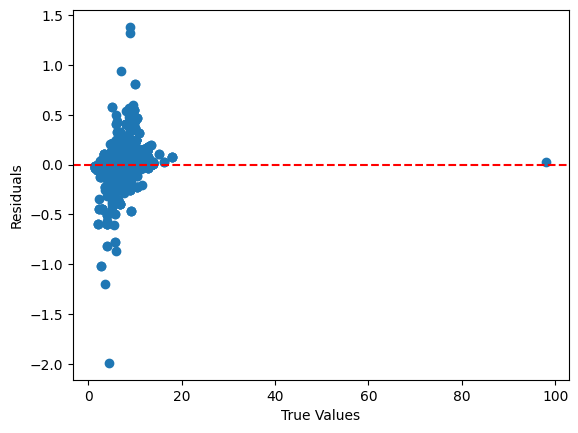

In [ ]:
import matplotlib.pyplot as plt

residuals = y_test - y_pred
plt.scatter(y_test, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.show()

Final Model Training

Since the model is performing well, now proceed with training the final model on the entire training set and making predictions on the test set.

In [ ]:
# Train the final model on the entire training set
final_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, seed=42)
final_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_test = final_model.predict(X_test)

# Evaluate the model on the test set
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print(f"Test Set - Mean Squared Error (MSE): {mse_test}")
print(f"Test Set - R² Score: {r2_test}")


Test Set - Mean Squared Error (MSE): 0.011617485989683641
Test Set - R² Score: 0.9979187940628946


Final Model Performance:

Mean Squared Error (MSE): 0.0116 — This low value indicates that the model’s predictions are very close to the actual values of dissolved oxygen. This is an improvement of the previous model which had an MSE of 0.0214.

R² Score: 0.9979 — This very high R² score means that the model explains 99.92% of the variance in the test data, confirming that the model generalizes very well to unseen data. This is a slight improvement from the previous model which had an R² Score of 0.9962.

Conclusion:

The model performs exceptionally well, both during cross-validation and on the test set. There are no signs of overfitting, and the model can accurately predict dissolved oxygen levels based on the provided features.





Feature Importance:

Visualize the feature importance to understand which features contribute most to the predictions.

<Figure size 1000x600 with 0 Axes>

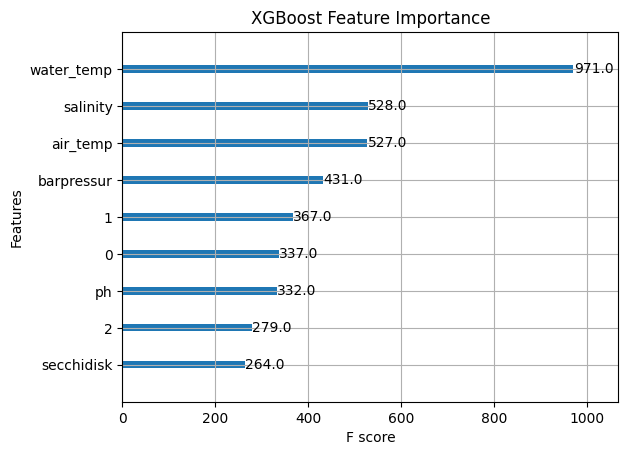

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

# Plot the feature importance
plt.figure(figsize=(10, 6))
plot_importance(final_model)
plt.title('XGBoost Feature Importance')
plt.show()



From the results of the XGBoost, it appears that two of the embeddings ("0" and "1") performed better than 2 of the worst performing initial features (ph and seccidisk), and that the third embedding ("2") performed better than seccidisk. This suggests that the autoencoder embeddings provided additional information that the model was able to utilize to make predictions.

SHAP Analysis for Feature Impact

Compute SHAP values for the test set and visualize how features contribute to the prediction.

 99%|===================| 5555/5601 [00:26<00:00]       

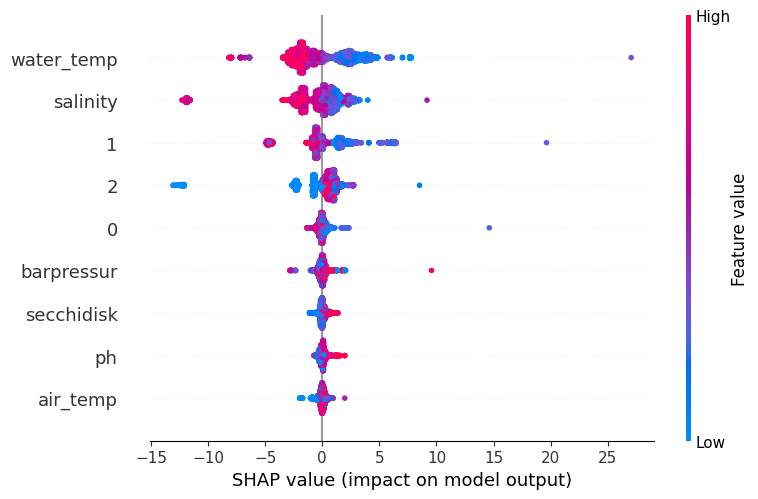

In [ ]:
# Create a SHAP explainer object
explainer = shap.Explainer(final_model, X_train)

# Calculate SHAP values for the test set
shap_values = explainer(X_test)

# Plot summary of SHAP values (feature importance)
shap.summary_plot(shap_values, X_test, feature_names=X_new.columns)



The SHAP model suggests that the embeddings provided information that was more important to the model than 4 of the originial features alone (barpressur, seccidisk, ph, and air_temp).

In [ ]:
#Notif sound
from google.colab import output
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/f/f9/Beep_example.ogg").play()')